# Docking with REINVENT

This is an example of how to use REINVENT with Maize in a reinforcement learning workflow. This is a more advanced workflow, for the Maize basics see the plain docking workflows without REINVENT. The idea here is to use a dedicated node for REINVENT generating SMILES and receiving scores. The scores are generated through docking, with a subset of ligands sent to a high-precision docking node performing a more thorough search through poses.

.. caution::
   This is an example workflow not meant for production use, none of the settings are optimised for scientific accuracy or efficiency. It is only meant to showcase Maize's complex workflow capabilities.

## Imports

We begin with all top-level requirements and imports, and ensure our software dependencies are setup correctly.

In [1]:
from pathlib import Path

from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult, Return, Void
from maize.steps.plumbing import MergeLists
from maize.steps.mai.cheminformatics import RMSD, ExtractScores, TagIndex, SortByTag, TagSorter, LogTags
from maize.steps.mai.docking.adv import AutoDockGPU
from maize.steps.mai.molecule import Gypsum, LoadMolecule
from maize.steps.mai.misc import ReInvent
from maize.utilities.chem import IsomerCollection

## Workflow
We use the same configuration as before, note that you will need to setup the required software yourself.

In [2]:
flow = Workflow(name="dock", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

We begin by creating all the required nodes. The workflow will be circular, with the `ReInvent` node creating SMILES and accepting scores. Because our list of molecules will be split after the first docking and later re-merged, we need to keep track of the order of molecules. We do this by setting the index for each molecule as a tag (`TagIndex`), and later sorting the final list based on this tag (`SortByTag`). The RMSD, with which we determine if a molecule should be sent to a more accurate docking node, essentially acts as a scoring function. `TagSorter` can then decide where to send subsets of the molecules. Finally, the lists of molecules are merged (`MergeLists`) and sorted (`SortByTag`) to restore the original order given by Reinvent.

In [3]:
rnve = flow.add(ReInvent)
embe = flow.add(Gypsum, loop=True)
indx = flow.add(TagIndex, loop=True)
dock = flow.add(AutoDockGPU, loop=True)
void = flow.add(Void)
load = flow.add(LoadMolecule)
rmsd = flow.add(RMSD, loop=True)
logt = flow.add(LogTags, loop=True)
sort = flow.add(TagSorter, loop=True)
dock_hp = flow.add(AutoDockGPU, name="dock-hp", loop=True)
void_hp = flow.add(Void, name="void-hp", loop=True)
merg = flow.add(MergeLists[IsomerCollection])
sort_id = flow.add(SortByTag, loop=True)
scor = flow.add(ExtractScores, loop=True)

Three separate calls to `flow.connect_all()` are required to get static typing on inputs and outputs. If you don't care about this you can just make a single call. This is an unfortunate limitation of the python typing system and may be resolved in the future.

In [4]:
flow.connect_all(
    (rnve.out, embe.inp),
    (embe.out, indx.inp),
    (indx.out, dock.inp),
    (dock.out_scores, void.inp),
    (dock.out, rmsd.inp),
    (load.out, rmsd.inp_ref),
)
flow.connect_all(
    (rmsd.out, logt.inp),
    (logt.out, sort.inp),
    (sort.out, merg.inp),
    (sort.out, dock_hp.inp),
    (dock_hp.out_scores, void_hp.inp),
    (dock_hp.out, merg.inp),
)
flow.connect_all(
    (merg.out, sort_id.inp),
    (sort_id.out, scor.inp),
    (scor.out, rnve.inp),
)

### Parameters
Parameters required for this workflow are the Reinvent configuration, the docking grid, and the reference pose.

In [5]:
grid = Path("../maize/steps/mai/docking/data/1uyd.tar")
ref = Path("../maize/steps/mai/docking/data/1UYD_ligand.sdf")
rnv_config = Path("../maize/steps/mai/misc/data/input-intercept.toml")
prior = Path("../maize/steps/mai/misc/data/reinvent.prior")

In [6]:
# The REINVENT configuration, excluding any entries for maize (these will be added automatically)
rnve.configuration.set(rnv_config)
rnve.prior.set(prior)
rnve.agent.set(prior)

# The maximum number of RL epochs
rnve.max_epoch.set(10)

# Settings to transform the docking score to a value between 0 and 1, with 1 being favourable, using a sigmoid
rnve.low.set(-10.0)
rnve.high.set(-5.0)
rnve.reverse.set(True)

# Number of molecules to generate each epoch
rnve.batch_size.set(32)

# Number of isomers to generate for each SMILES
embe.n_variants.set(4)

# Docking grid for 1UYD
dock.inp_grid.set(grid)
dock_hp.inp_grid.set(grid)

# Reference ligand for RMSD calculation
load.path.set(ref)

# Log the "rmsd" tag
logt.tag.set("rmsd")

# Send molecules with RMSD higher than 6 Ang to high-precision docking
sort.sorter.set(["rmsd < 6.0", "rmsd >= 6.0"])

# More extensive search settings for "high-precision" docking
dock_hp.nrun.set(50)
dock_hp.population_size.set(300)
dock_hp.lsit.set(500)

# Deactivate constraints from the grid
dock.constraints.set(False)
dock_hp.constraints.set(False)

### Check
If this method doesn't throw an exception, we have connected everything correctly and set all required parameters.

In [7]:
flow.check()

### Topology
We can visualize our workflow by simply showing the workflow object representation (or using `flow.visualize()` outside of notebooks).

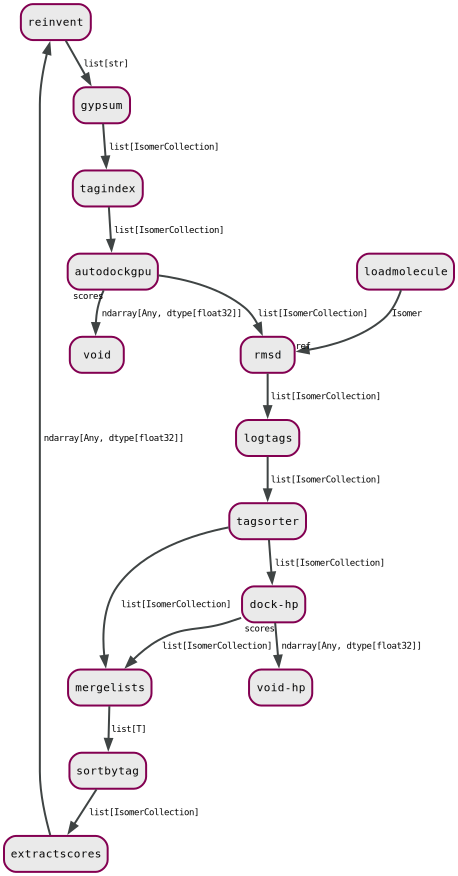

In [8]:
flow

## Run
Run the workflow, it will exit once REINVENT has completed all iterations

In [ ]:
flow.execute()